# DRIAS - Projections climatiques quotidiennes MULTI MODELES
## Calcul d'indicateur et de sa médiane multi modèles pour la moyenne des mailles choisies
https://github.com/loicduffar/

<b>Champ d'application de cette version du code:</b>
- indicateurs calculés : uniquement les quantiles de valeurs mensuelles et annuelles, pour apprécier la variabilité inter annuelle de 5 paramètres possibles.
- Les paramètres traités à ce jour sont: précipitations totales, températures (moy, min et max) et ETP Hargreaves-
- métropole uniquement: A termes les données DRIAS des DROM-COM pourront être traitées, pour la Réunion et les Antilles notamment (en attendant, la version mono modèle de ce code répond partiellement au besoin, car les données des DROM-COM inclent un modèle unique).

<b>Principe du code:</b>
- La version actuelle du script calcule à partir des données quotidiennes DRIAS la distribution de fréquence (quantiles) des valeurs mensuelles et annuelles, d'une part pour la référence 1976-2005 et d'autre part pour chacun des 3 horizons standards DRIAS 2021-2050, 2041-2070 et 2071-2100.
- L'indicateur est calculé ...
    - ... à chaque run pour un paramètre unique et un scénario unique, (et un unique indicateur est prévu pour chaque paramètre à ce jour)
    - ...sur la moyenne des points de maille définis par l'utilisateur par leur numéro DRIAS (à charge pour l'utilisateur d'en faire une liste car ce code ne gère pas les coordonnées géographiques dans le soucis de limiter l'effort de programmation),
    - ...pour la médiane de tous les modèles fournis par l'utilisateur (12 en principe),
    - ... avec une agrégation mensuelle et annuelle, adaptée automatiquement à la nature de chacun des 5 paramètres possibles: somme (précipitation, ETP),  moyenne, minimum ou maximum (température moyenne, min ou max quotidienne)
 
<b>Etapes à suivre par l'utilisateur:</b>
- 1. Télécharger les fichiers quotidiens sur le <a href="/media/examples/link-element-example.css"> site DRIAS</a> (voir ci-dessous les caractéristiques obligatoires des fichiers)
- 2. Stocker dans un même dossier tous les fichiers des différents modèles (12 en principe) et différents scénarios à traiter pour la zone géographique voulue
- 3. Faire tourner le code après avoir renseigné les options à personaliser (dossier, nom de fichier, paramètre climatique voulu, points de maille voulus etc...).
- 4. Les résultats sont stockés dans un fichier Excel

<b>Contraintes de téléchargement des données:</b>

<font color="red"> L'ergonomie du portail DRIAS impose un long processus de téléchargement de très nombreux fichiers</font><br>
En effet, pour une certaine étendue spatiale et pour chacun des 12 modèles, il est nécessaire de télécharger individuellement 1 fichier historique 1950-2005 et 1 fichier pour chaque scénario futur. Pour 12 modèles, cela fait donc 24 fichiers nécessaires pour un scénario unique et 36 pour 2 scénarios ! De plus, le portail impose un nombre maximum de lignes pour chaque fichier,  ce qui qui limite le choix de téléchargement en termes de nombre de paramètres et d'étendue spatiale . Pour 5 paramètres par exemple (précipitations, température moy/max/min, ETP), chaque fichier ne peut excéder l'étendue approximative d'un département français.

Les options de téléchargement suivantes doivent être respectées strictement:
- format CSV (en réalité extension TXT)
- séparateur point virgule
- Date sur 1 seul champ &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(et non dans plusieurs champs jour, mois et année) 
- champ idPoint &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(pour identifier les mailles voulues)
- champ Flag_terre&emsp;&emsp;&emsp;&emsp;(pour l'outre mer uniquement, car les fichiers contiennent également l'océan pour chaque archipel des Antilles ou du Pacifique)
- Chaque fichiers peut contenir des points multiples et des paramètres multiples, en s'assurant que les différents fichiers ont en commun les mêmes paramètres et points voulus ainsi que l'unité. DE PLUS le nombre de lignes d'entête doit également être commun à tous les fichiers, ce qui n'est pas le cas pour certains modèles dont il faut supprimer ou ajouter quelques lignes d'entête à la main à l'aide d'un éditeur de texte.
- NB: Le traitement utilise le nom de modèle présent dans le nom des fichiers, ainsi que le nom de scénario ou le mot 'Historical'.

## 1) Personalisation & constitution de la liste des fichiers
A renseigner par l'utilisateur:
- dossiers d'entrée et de sortie,
- Liste correcte des modèles à prendre en compte (de préférence la totalité des 12 modèles)- Liste correcte des modèles à prendre en compte (de préférence la totalité des 12 modèles)
- Scénario à traiter
- paramètre, type d'agrégation annuelle (somme ou moyenne) et unité (indicatif pour la légende)
- points de maille à moyenner
- Nombre de ligne d'entête des fichiers 
- Numéro de ligne contenant les noms de colonnes/paramètres des fichiers (cette 2 dernières informations dépendent du nombre de paramètres téléchargés par l'utilisateur)

In [98]:
"""
Created on december 2022
@author: Loïc Duffar
https://github.com/loicduffar
"""
import os
import glob2

# =========== Personalisation par l'utilisateur à chaque run
# .......... Dossiers d'entrée et sortie
fld_in= r"X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat France\Changement climatique\DRIAS\La Réunion\Historique journalier"
fld_in= r"X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat France\Changement climatique\DRIAS\PACA\Journaliers\04\TXT"
fld_out= r"X:\1-COMMUN\DIS\Documentation\Hydrologie\Documentation externe\Climat France\Changement climatique\DRIAS\PACA\Journaliers\04"

# .......... Modèles et scénarios à lire et traiter
# Nom exact du couple de modèles GCM_RCM apparaissant dans le nom des fichiers (le couple entier est nécessaire car ni les GCM ni les RCM ne sont uniques entre tous les couples)
# Attention : Pour le scénario 4.5, 2 modèles sont indisponibles et doivent être exclus de la liste : 'MOHC-HadGEM2-ES_ICTP-RegCM4-6' & 'NCC-NorESM1-M_GERICS-REMO2015'
models= ['CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63', 'CNRM-CERFACS-CNRM-CM5_KNMI-RACMO22E', # 12 Modèles de Métropole
         'ICHEC-EC-EARTH_KNMI-RACMO22E', 'ICHEC-EC-EARTH_SMHI-RCA4', 'IPSL-IPSL-CM5A-MR_IPSL-WRF381P', 'IPSL-IPSL-CM5A-MR_SMHI-RCA4', 'MOHC-HadGEM2-ES_CLMcom-CCLM4-8-17', 
         'MOHC-HadGEM2-ES_ICTP-RegCM4-6', 'MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17', 'MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009', 'NCC-NorESM1-M_DMI-HIRHAM5', 'NCC-NorESM1-M_GERICS-REMO2015',
         ]
models= ['CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63', 'CNRM-CERFACS-CNRM-CM5_KNMI-RACMO22E', # 10 modèles de Métropole du scénario 4.5 (2 modèles sont indisponibles)
         'ICHEC-EC-EARTH_KNMI-RACMO22E', 'ICHEC-EC-EARTH_SMHI-RCA4', 'IPSL-IPSL-CM5A-MR_IPSL-WRF381P', 'IPSL-IPSL-CM5A-MR_SMHI-RCA4', 'MOHC-HadGEM2-ES_CLMcom-CCLM4-8-17', 
         'MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17', 'MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009', 'NCC-NorESM1-M_DMI-HIRHAM5', 
         ]
# Nom exact du scénario apparaissant dans le nom des fichiers (rcp8.5 par exemple)
scenario= 'rcp4.5'

# .......... Paramètre unique à traiter dans le run
# Précipitations: 'prtotAdjust'
# ETP Hargreaves: 'evspsblpotAdjust'
# Température moyenne quotidienne: 'tasAdjust'
# Température mini quotidienne: 'tasminAdjust'
# Température maxi quotidienne: 'tasmaxAdjust'
param= 'evspsblpotAdjust'

# .......... Points de maille à moyenner
points= [4817]                                     # Apt (84)
points= [4103]                                     # Aix en Provence (13)
points= [3826, 3969]                               # Le Luc (83)
points= [4680, 4681, 4823, 4824]                   # Valensole (04)

# ATTENTION pour que skiprows et num_line_header soient communs à tous les fichiers, il est nécessaire d'ajuster à la main dans un éditeur de texte le nombre de lignes d'entête
# En effet, pour certains modèles le nombre de lignes d'entête est plus long ou plus court de 1 à 3 lignes
# .......... Nombre de lignes à sauter au début des fichiers 
skiprows = 56 # Outre-mer
skiprows = 65 # Métropole

# .......... Numéro de ligne (commencant à 1) contenant la liste des colonnes 
num_line_header= 39

# .......... Colonne(s) servvant à indexer le dataframe de travail
index_col= ['Flag_terre-mer','idPoint', 'Date']                 # Outre-mer
index_col= ['idPoint', 'Date']
index_col= ['Date']                                             # Métropole

# =========== Initialisations réservées au programmeur
if param== 'prtotAdjust':                                       # précipitations totales (y compris précipitations solides neige et grêle)
    param_long= 'Précipitations'
    unite= 'mm'                                                 # indicatif pour la légende des tableaux et des graphiques (évitez donc l'unité par défaut kg/m2/s en téléchargeant les fichiers)
    aggreg= 'sum'                                               # opération d'agrégation mensuelle et annuelle 
elif param== 'evspsblpotAdjust':                                # Evapotranspiration potentielle quotidienne Hargreaves
    param_long= 'ETP Hargreaves'
    unite= 'mm'
    aggreg= 'sum'    
elif param== 'tasAdjust':                                       # Température moyenne quotidienne
    param_long= 'Température moyenne'
    unite= '°C'                                                 # indicatif pour la légende des tableaux et des graphiques (évitez donc l'unité par défaut °Kelvin en téléchargeant les fichiers)
    aggreg= 'mean'
elif param== 'tasminAdjust':                                    # Température mini quotidienne
    param_long= 'Température minimum'
    unite= '°C'
    aggreg= 'min'
elif param== 'tasmaxAdjust':                                    # Température maxi quotidienne
    param_long= 'Température maximum'
    unite= '°C'
    aggreg= 'max'

nround= 1                                                       # nombre de chiffres après la virgule des valeurs climatiques
periods_of_years_h= [[1976, 2005]]# Période de référence Historique commençant en 1976 et conforme à celle des INDICATEURS DRIAS standards (et est commune à tous les modèles même si la plupart des modèles commencent plutôt en 1951 ou 1951)
periods_of_years_f= [[2021, 2050], [2041, 2070], [2071, 2100]]  # 3 périodes de 30 années conformes à celles des INDICATEURS MENSUELS DRIAS standards (ce qui assure une cohérence avec l'INDICATEUR calculé par ce code)

frequences= [0.95, 0.9, 0.8, 0.5, 0.2, 0.1, 0.05]               # périodes de retour 20, 10 et 5 ans + médiane
freq_names= ['20 ans humide', '10 ans humide', '5 ans humide', 'Médiane', '5 ans sec', '10 ans sec', '20 ans sec']

# =========== Construction de la liste des fichiers
# .......... Liste de tous les fichiers présents dans le dossier d'entrée
files_historical= glob2.glob(os.path.join(fld_in, '*historical*.txt'))
files_futur= glob2.glob(os.path.join(fld_in, '*' + scenario + '*.txt'))

files_historical= [os.path.basename(file) for file in files_historical]
files_futur= [os.path.basename(file) for file in files_futur]

# display('Fichiers de référence historique:', files_historical)
# display('Fichiers de scénario futur:',files_futur)

# .......... Retrait de la liste des fichiers, des modèles non demandés par l'utilisateur (et classement alphabétique par nom de modèle)
files_hist= []
files_fut= []
# 
models.sort()# Classement alphabétique du nom des modèles
for model in models: # retrait de la liste des fichiers non demandés, en même temps que classement dans le MEME ORDRE que les modèles
    for file in files_historical:
        if model in file: files_hist.append(file)

    for file in files_futur:
        if model in file: files_fut.append(file)

files_historical= files_hist
files_futur= files_fut

print()
print("FICHIERS TROUVES (du moins ceux qui correspondent aux modèles demandés par l'utilisateur)")
display('Fichiers de référence historique:', files_historical)
print()
display('Fichiers de scénario futur:',files_futur)

# .......... Alerte si tous les modèles ne disposent pas à la fois d'un fichier historique et d'un fichier futur
if len(files_futur) != len(files_historical):
    print()
    print("ATTENTION: Il n'y a pas le même nombre de fichiers historiques et de fichiers futurs")


FICHIERS TROUVES (du moins ceux qui correspondent aux modèles demandés par l'utilisateur)


'Fichiers de référence historique:'

['tasmintasmaxtasprtotevspsblpot_France_CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_Historical_day_19510101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_CNRM-CERFACS-CNRM-CM5_KNMI-RACMO22E_Historical_day_19500101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_ICHEC-EC-EARTH_KNMI-RACMO22E_Historical_day_19500101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_ICHEC-EC-EARTH_SMHI-RCA4_Historical_day_19700101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_IPSL-IPSL-CM5A-MR_IPSL-WRF381P_Historical_day_19510101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_IPSL-IPSL-CM5A-MR_SMHI-RCA4_Historical_day_19700101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MOHC-HadGEM2-ES_CLMcom-CCLM4-8-17_Historical_day_19500101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17_Historical_day_19500101-20051231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009_Historical_day_19500101-20051231.txt',
 

'Fichiers de scénario futur:'

['tasmintasmaxtasprtotevspsblpot_France_CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_CNRM-CERFACS-CNRM-CM5_KNMI-RACMO22E_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_ICHEC-EC-EARTH_KNMI-RACMO22E_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_ICHEC-EC-EARTH_SMHI-RCA4_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_IPSL-IPSL-CM5A-MR_IPSL-WRF381P_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_IPSL-IPSL-CM5A-MR_SMHI-RCA4_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MOHC-HadGEM2-ES_CLMcom-CCLM4-8-17_rcp4.5_day_20060101-20991130.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MPI-M-MPI-ESM-LR_CLMcom-CCLM4-8-17_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_France_MPI-M-MPI-ESM-LR_MPI-CSC-REMO2009_rcp4.5_day_20060101-21001231.txt',
 'tasmintasmaxtasprtotevspsblpot_Fran

## 2) Lecture des fichiers et extraction des séries chronologiques quotidiennes pour la moyenne des mailles

In [ ]:
import hvplot
import hvplot.pandas
import plotly.express as px
# import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

# +++++++++++++++++++ Lecture des fichiers
print("DEMARRAGE DE LA LECTURE - Attendre jusqu'à 5 minutes l'affichage des graphiques représentant les séries chronologiques passées et futures")
start= datetime.now()# Start Timer

fig= [0, 0]
for j, files_in in enumerate([files_historical, files_futur]):# boucle sur les 2 types de fichiers "historique" et "futur"
    for i, file in enumerate(files_in):         # boucle sur les fichiers correspondant aux différents modèles
        model= models[i]
        with open(os.path.join(fld_in, file), 'r', encoding="utf-8") as file_object:
            content = file_object.readlines(2000)
            line= content[num_line_header-1]
        header= line.split('"')[1].split()
        print("------------", i+1, file)
    # .......... Lecture du fichier ENTIER AVEC TOUTES LES MAILLES
        df = pd.read_table(os.path.join(fld_in, file), skiprows= skiprows, delimiter=";", index_col= index_col, parse_dates= True, names= header)
    # .......... df: Création du dataframe quotidien avec la MOYENNE DES MAILLES CHOISIES par l'utilisateur, pour TOUS LES PARAMETRES
        df= df[df['idPoint'].isin(points)]
        df_points= df[['idPoint', 'Latitude', 'Longitude']]
    # Mémoriser les coordonnées des points https://stackoverflow.com/questions/47562201/finding-only-unique-coordinates-in-list
        coords= [ x+1j*y for (x,y) in df_points[['Latitude', 'Longitude']].values] # using complex; a way for grouping 
        unique_points= [ [x.real, x.imag] for x in np.unique(coords) ] # ungroup
    # ..................................................................
        df= df.groupby(['Date']).mean()
        df.drop(columns= ['idPoint'], inplace= True)
        # suppresion des champs non utilisés à ce jour et éventuellement présents (pour limiter l'occupation mémoire)
        df.drop(columns= ['Latitude', 'Longitude', 'Altitude'], inplace= True, errors='ignore')
    # .......... Mémorisation des données POUR LE SEUL PARAMETRE CHOISI 
        if i == 0:
            df_daily= df[param].to_frame()
            df_daily.rename(columns= {param: model}, inplace= True)
        else:
            df, df_daily= df.align(df_daily, axis=0)
            df_daily[model]= df[param]
    
    # del df# effacement du dataframe temporaire pour limiter l'occupation mémoire
    
    # .......... df_daily_h & df_daily_f: dataframes des données journalières historique et futur pour LE SEUL PARAMETRE CHOISI
    daily_title= 'DRIAS données quotidiennes'
    if files_in== files_historical:
        df_daily_h= df_daily
        daily_title= daily_title + ' historiques'
    elif files_in== files_futur:
        df_daily_f= df_daily
        daily_title= daily_title + ' futures ' + ' - ' + scenario
    
    # .......... Graphiques plotly 
    pd.options.plotting.backend = "plotly"# replace default pandas backend (matplotlib) by plotly
    colors= px.colors.qualitative.D3
    fig[j] = df_daily.plot(width=1300, height=400, color_discrete_sequence= colors, 
                  title= daily_title + ' - ' + param_long)
    for data in fig[j]['data']:
        data['line']['width']=1
    # fig.update_traces(visible= 'legendonly')
    fig[j].update_layout(showlegend= True, yaxis_title= unite, legend_title_text= "Modèles", hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
    fig[j].update_traces(visible= 'legendonly', hovertemplate= '%{y:.1f}')
    fig[j].for_each_trace(lambda trace: trace.update(visible=True) if trace.name == models[0] or trace.name == models[1] else (),)# https://stackoverflow.com/questions/66414456/update-visibility-of-traces-with-fig-update-layout-plotly
    fig[j].write_html(os.path.join(fld_out, daily_title + ' - ' + param_long + '.html'))
    # fig[j].write_image(os.path.join(fld_out, daily_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

stop = datetime.now()
print("LECTURE TERMINEE. Durée: ", (stop - start)/60)
fig[0].show()
fig[1].show()

# +++++++++++++++++++ Affichage de la carte des points de maille trouvés dans le fichier
map_title= 'DRIAS - Points de maille moyennés'
df_points= pd.DataFrame(unique_points)
df_points.rename(columns= {0: 'lat', 1:'lon'}, inplace= True)
fig = px.scatter_mapbox(lat= df_points['lat'], lon= df_points['lon'], mapbox_style= "open-street-map", title= map_title, height= 500, width= 700, 
                         color_discrete_sequence= ['red'], size= [1 for i in range(len(df_points))],size_max= 10)
fig.show()
fig.write_html(os.path.join(fld_out, map_title + '.html'))
fig.write_image(os.path.join(fld_out, map_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

## 3) Agrégation mensuelle et annuelle des séries chronologiques

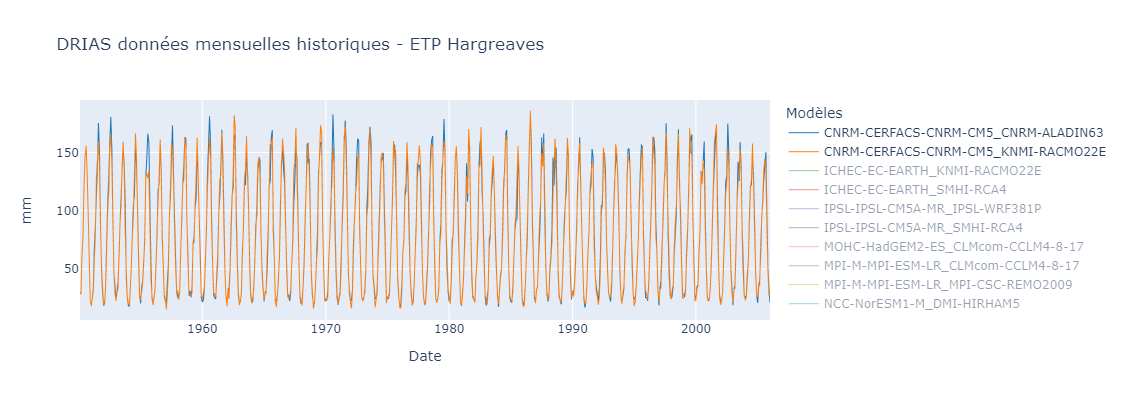

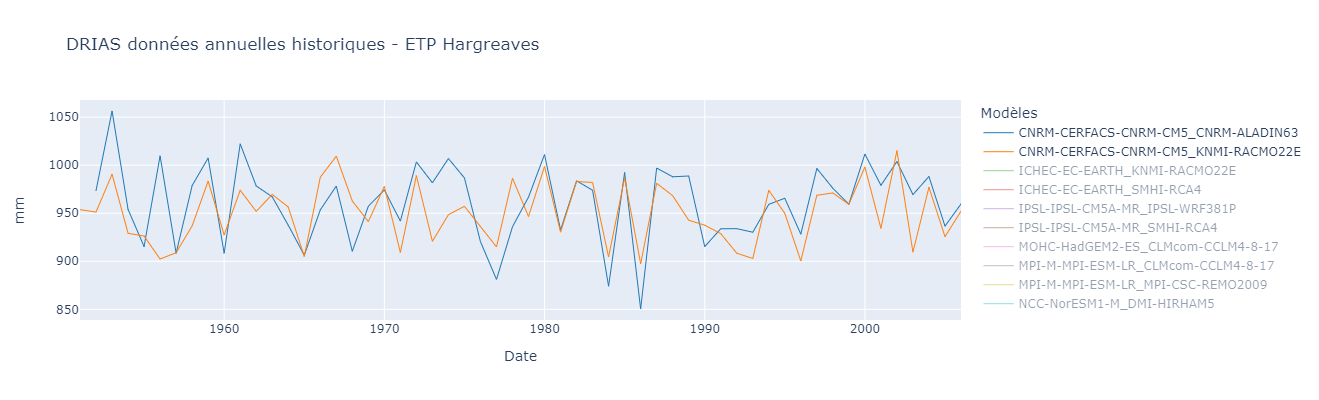

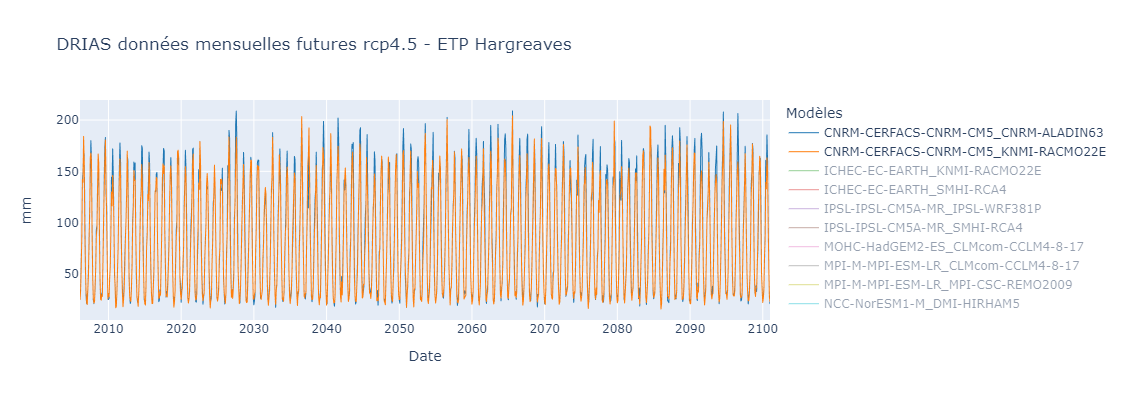

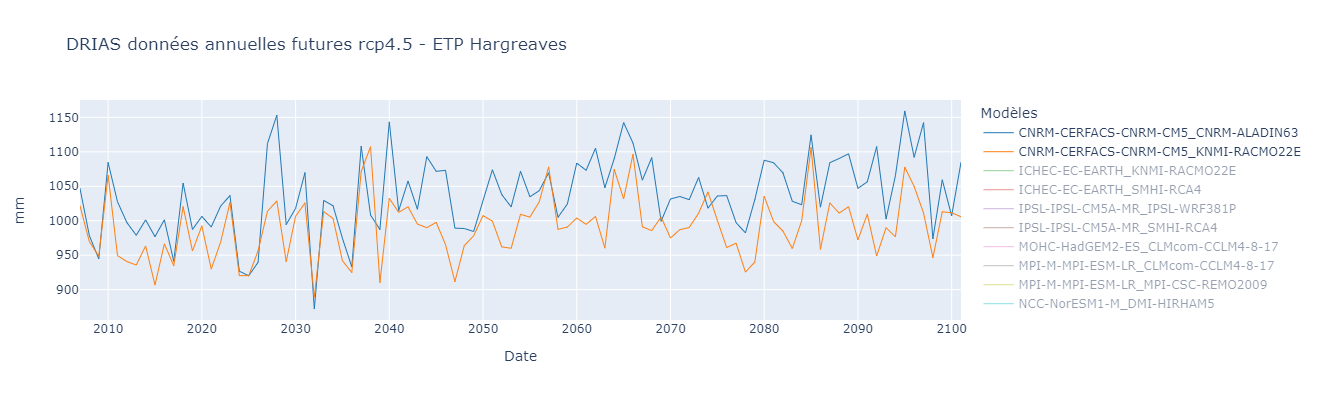

In [100]:
import numpy as np

for i, df_daily in enumerate([df_daily_h, df_daily_f]):
    resampler_monthly= df_daily.resample('M')
    resampler_yearly= df_daily.resample('Y')
    if aggreg== 'sum':
        df_monthly= resampler_monthly.sum(min_count= 28)   # NB: l'argument "min_count" n'est utile que pour "sum" qui contrairement à "mean" donne zéro pour l'agrégation de valeurs NA
        df_yearly= resampler_yearly.sum(min_count= 28)    # NB: l'argument "min_count" n'est utile que pour "sum" qui contrairement à "mean" donne zéro pour l'agrégation de valeurs NA
    elif aggreg== 'mean':
        df_monthly= resampler_monthly.mean()
        df_yearly= resampler_yearly.mean()
    elif aggreg== 'max':
        df_monthly= resampler_monthly.max()
        df_yearly= resampler_yearly.max()
    elif aggreg== 'min':
        df_monthly= resampler_monthly.min()
        df_yearly= resampler_yearly.min()
    # df_monthly.rename(columns= {param: models[num_model]}, inplace= True)# A FAIRE: Incrémenter le nom du modèle quand plusieurs modèles seront traités
    
    monthly_title= 'DRIAS données mensuelles'
    yearly_title= 'DRIAS données annuelles'
    if i == 0:
        df_monthly_h= df_monthly
        monthly_title= monthly_title + ' historiques'
        yearly_title= yearly_title + ' historiques'
    elif i == 1:
        df_monthly_f= df_monthly
        monthly_title= monthly_title + ' futures ' + scenario
        yearly_title= yearly_title + ' futures ' + scenario
        
    # .......... Graphiques plotly 
    pd.options.plotting.backend = "plotly"         # replace by plotly the default pandas backend (matplotlib)
    colors= px.colors.qualitative.D3   
    # mensuel
    fig = df_monthly.plot(width=1300, height=400, color_discrete_sequence= colors, 
                  title= monthly_title + ' - ' + param_long)
    for data in fig['data']:
        data['line']['width']=1
    fig.update_layout(showlegend= True, yaxis_title= unite, legend_title_text= "Modèles", hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
    fig.update_traces(visible= 'legendonly', hovertemplate= '%{y:.1f}')
    fig.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == models[0] or trace.name == models[1] else (),)    
    fig.show()
    fig.write_html(os.path.join(fld_out, monthly_title + ' - ' + param_long + '.html'))
    # fig.write_image(os.path.join(fld_out, monthly_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

    # annuel
    fig = df_yearly.plot(width=1300, height=400, color_discrete_sequence= colors, 
                  title= yearly_title + ' - ' + param_long, )
    for data in fig['data']:
        data['line']['width']=1
    fig.update_layout(showlegend= True, yaxis_title= unite, legend_title_text= "Modèles", hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
    fig.update_traces(visible= 'legendonly', hovertemplate= '%{y:.1f}')
    fig.for_each_trace(lambda trace: trace.update(visible=True) if trace.name == models[0] or trace.name == models[1] else (),)
    fig.show()
    fig.write_html(os.path.join(fld_out, yearly_title + ' - ' + param_long + '.html'))
    # fig.write_image(os.path.join(fld_out, yearly_title + '.png'))# needs installation of "plotly-orca" or "kaleido"


## 4) Calcul de l'indicateur 'QUANTILES MENSUELS/ANNUELS' (Médiane des différents modèles)
NB: 
- Migrer dès que possible vers NUMPY >= 1.22 (dont la fonction 'quantile' dispose de l'argument method= 'weibull') au lieu de 1.215 dont la fonction 'quantile'  renvoie le minimum et le maximum pour les fréquences 0 et 1.
- Cet algroritme comporte une subitilité pour masquer de légères incohérences APPARENTES entre les valeurs ANNUELLES et les valeurs MENSUELLES dans certains cas. En effet la médiane des 12 modèles ne permet pas de trouver des précipitations annuelles moyennes identiques à la somme des précipitations mensuelles moyennes ce qui est statistiquement correct mais difficile à faire comprendre. Par conséquent les valeurs ANNUELLES sont d'abord calculées comme la médiane de tous les modèles, puis les colonnes Moy. Max et Min sont ensuite recalculées selon la logique ci-dessous:<br>
    - pour les précipitations, l'ANNUEL est recalculé comme la somme des précipitations MENSUELLES pour la colonne 'Moy.' (mais pas pour les colonnes 'Max', 'Min' et quantiles).
    - pour la température journalière maximums, l'ANNUEL est recalculé comme le maximum des températures max MENSUELLES pour la colonne 'Max' (mais pas pour les colonnes 'Moy.', 'Min' et quantiles).
    - idem pour la température minimum et la colonne 'Min'

In [101]:
import plotly.graph_objects as go
import calendar
import locale
import hvplot.pandas
locale.setlocale(locale.LC_ALL, 'fr_FR')                   # pour que le nom des mois soit français

# *************** Initialisation des graphiques plotly (non utilisé car spécifique au graphique des quantiles de 12 mois sur un même graphique)
quantile_title_begin= 'Quantiles expérimentaux mensuels'
color_min_max= 'violet' # https://www.w3schools.com/colors/colors_names.asp
color_median_mean= '#1f77b4'
color_20= 'red'
color_10= 'orange'
color_5= 'yellowgreen'
color_list= [color_20, color_10, color_5, color_median_mean, color_5, color_10, color_20] 
pd.options.plotting.backend = "matplotlib"                  # restore the default pandas backend to matplotlib
#pd.options.plotting.backend = "plotly"                     # replace default pandas backend (matplotlib) by plotly

# *************** Calcul de l'indicateur 
for i, df_monthly in enumerate([df_monthly_h,df_monthly_f]):# Boucle sur les 2 dataframes "Historique" et "Futur"

    for j, model in enumerate(models):                      # Boucle sur les différents modèles
        if i == 0:# Historical
            periods_of_years= periods_of_years_h
        elif i == 1:# Future
            periods_of_years= periods_of_years_f
                
        for k, period in enumerate(periods_of_years):       # Boucle sur les différentes périodes (une seule pour l'Historique et 3 pour le Futur)
            
           # ............... df_bymonth: Construction d'un dataframe temporaire pour le calcul de l'indicateur, avec les données sur 12 colonnes plus l'annuel
            df_bymonth= df_monthly[model].to_frame()[(df_monthly.index.year>= period[0]) 
                                                     & (df_monthly.index.year<= period[1])].copy()
            df_bymonth= df_bymonth.round(nround)
            df_bymonth['Mois']= list(df_bymonth.index.month)                          # Ajout d'une colonne 'Mois'
            df_bymonth['Année']= list(df_bymonth.index.year)                          # Ajout d'une colonne 'Année'
            df_bymonth= df_bymonth.pivot_table(index= 'Année', columns= 'Mois')       # Transposition sur 12 colonnes, avec l'année en index de ligne

            # ............... Agrégation annuelle de l'indicateur
            if aggreg== 'sum':                                                         # Agrégation annuelle de l'indicateur par somme des mois
                df_bymonth[(model, 'Annuel')]= df_bymonth.sum(axis= 1, min_count= 12)  # NB: l'argument "min_count" n'est utile que pour "sum" qui contrairement à "mean" produit zéro pour l'agrégation de valeurs NA
            elif aggreg== 'mean':                                                      # Agrégation annuelle par moyenne des mois
                df_bymonth[(model, 'Annuel')]= df_bymonth.mean(axis= 1)
            elif aggreg== 'max':
                df_bymonth[(model, 'Annuel')]= df_bymonth.max(axis= 1)
            elif aggreg== 'min':
                df_bymonth[(model, 'Annuel')]= df_bymonth.min(axis= 1)

            # ............... df_stat: Calcul des quantiles mensuels dans le dataframe temporaire df_stat (distribution de fréquence des pluies ou températures mensuelles)
            period_txt= '-'.join([str(period[0]), str(period[1])] )                   # période d'années sous forme de texte
            subset= df_bymonth.loc[period[0]:period[1], :]# subset de la période d'année
            df_stat = pd.DataFrame({'Moy.': subset.mean(axis= 0).round(nround)})         # ajout d'une colonne 'Moy.' (pour chacun des 12 mois)
            df_stat.rename_axis(columns= 'Fréq.' , inplace= True)                        # ajout d'un nom pour l'index des colonnes
            df_stat['Max'] = subset.max(axis= 0).round(nround)                           # ajout d'une colonne 'Max' (pour chacun des 12 mois)

            for freq in frequences:
                df_stat[freq] = subset.quantile(q= freq).round(nround)                   # ajout des colonnes des quantiles (pour chacun des 12 mois)
                # df_stat[freq] = subset.apply(np.quantile, q= freq, method= 'weibull').round(nround)  # REMPLACER LA LIGNE PRECEDENTE A CONDITION DE MIGRER VERS NUMPY >=1.22 (la version 1.215 ne dispose pas de l'arguement 'method')
            df_stat['Min'] = subset.min(axis= 0).round(nround)                            # ajout d'une colonne 'Min' (pour chacun des 12 mois)
            df_stat.insert(0, 'Période', [period_txt for i in range(13) ])                # ajout d'une colonne 'Période' (pour chacun des 12 mois)
            df_stat.rename_axis(index= ('Modèle', 'Mois'), inplace= True)
            df_stat.reset_index(inplace= True)                                            # supression de l'index de lignes avant de le redéfinir plus loin
            # df_stat.set_index(['Modèle', 'Période', 'Mois'], drop= True, inplace= True) # définition de l'index de lignes en intégrant la 'Période'
            df_stat.set_index(['Modèle', 'Période'], drop= True, inplace= True)           # définition de l'index de lignes en intégrant la 'Période' et en supprimant le 'Mois'
            # display(df_stat)
            
            # ............... df_stat_multi: Rangement des quantiles dans un dataframe unique pour tous les modèles
            if i==0 and j==0 and k==0:
                df_stat_multi= df_stat.copy()
            else:
                df_stat_multi= pd.concat([df_stat_multi, df_stat], axis= 'index')

            # ............... Graphique Plotly des quantiles des 12 mois sur le même graphique
            if i == 0:# Historical
                quantile_title_middle= ' Historiques '
            elif i == 1:# Futur
                quantile_title_middle= ' Futurs ' + scenario + ' '
            
            quantile_title= quantile_title_begin + quantile_title_middle + period_txt + ' - ' + model + ' - ' + param_long
            fig = go.Figure()
            x= [calendar.month_name[i] for i in range(1, 13)]
            fig.add_trace(go.Scatter(x= x, y= df_stat['Moy.'], name='Moy.', mode= 'lines', line=dict(color= color_median_mean)))
            fig.add_trace(go.Scatter(x= x, y= df_stat['Max'], name='Max', mode= 'lines', line=dict(color= color_min_max, dash= 'dash', width=1)))
            for i, (col, color) in enumerate(zip(df_stat.columns[3:-1], color_list)):
                fig.add_trace(go.Scatter(x= x, y= df_stat[col], name= freq_names[i], mode= 'lines', line=dict(dash= 'dash', width=1, color= color)))
            fig.add_trace(go.Scatter(x= x, y= df_stat['Min'], name= 'Min', mode= 'lines', line=dict(color= color_min_max, dash= 'dash', width=1)))
            fig.update_xaxes(tick0= 1, dtick= 1)
            fig.update_layout(hovermode= "x", title= {'text': quantile_title , 'x': 0.5}, width=1100, height=700,)
            # fig.show()
            # fig.write_html(os.path.join(fld_out, quantile_title + ' - ' + param_long + '.html'))
            # fig.write_image(os.path.join(fld_out, quantile_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

            # ............... df_out: dataframe transposé pour afficher les mois en colonnes (NON UTILISE A CE JOUR)
            # df_out= df_stat.reset_index()
            # df_out.loc[12, "Mois"]= "Annuel"
            # df_out= df_out.set_index('Mois')
            # df_out= df_out.pivot_table(columns= 'Mois')
            # # display(df_out)

# df_stat_multi: quantiles des valeurs mensuelles pour chacun des modèles, et pour chaque période passée et future (distributions de fréquence des pluies ou températures mensuelles) 
df_stat_multi.sort_index(inplace= True)# Forcage de l'indexation dont la mise à jour lors ne semble pas automatique lors de la construction du dataframe
print('QUANTILES MENSUELS/ANNUELS POUR CHAQUE MODELE ET CHAQUE PERIODE')
display(df_stat_multi.hvplot.table())

# *************** CALCUL DES QUANTILES MEDIANS DES DIFFERENTS MODELES POUR CHAQUE PERIODE
# ............... Construction des légendes de périodes
period_historical_txt= '-'.join( [str(periods_of_years_h[0][0]), str(periods_of_years_h[0][1])] )
periods_futur_txt = []
periods_futur_txt.append('-'.join( [str(periods_of_years_f[0][0]), str(periods_of_years_f[0][1])] ))
periods_futur_txt.append('-'.join( [str(periods_of_years_f[1][0]), str(periods_of_years_f[1][1])] ) )
periods_futur_txt.append('-'.join( [str(periods_of_years_f[2][0]), str(periods_of_years_f[2][1])] ) )

# ............... Calcul de quantiles médians des modèles et stochage dans le dataframe df_monthly_quant
df_monthly_quant= df_stat_multi.reset_index(inplace= False)[df_stat_multi.reset_index(inplace= False)['Période'] == period_historical_txt].groupby(['Mois']).median()
df_monthly_quant.reset_index(inplace= True)
df_monthly_quant.insert(0, 'Période', [period_historical_txt for i in range(13)])
   
for j, period_txt in enumerate(periods_futur_txt):
    df_stat= df_stat_multi.reset_index(inplace= False)[df_stat_multi.reset_index(inplace= False)['Période'] == period_txt].groupby(['Mois']).median()
    df_stat.reset_index(inplace= True)
    df_stat['Période']= [period_txt for i in range(13)]
    df_monthly_quant= pd.concat([df_monthly_quant, df_stat], axis= 'index')

df_monthly_quant.set_index(['Période', 'Mois'], inplace= True)

# ............... Agrégation ANNUELLE des quantiles DANS CERTAINS CAS
# Tentative d'assurer une corhérence entre les valeurs ANNUELLES et MENSUELLES
# En effet à la base les valeurs ANNUELLES sont les médianes de tous les modèles, mais dans certains cas cela conduit à une incohérence avec les valeurs MENSUELLES
if param == 'tasmaxAdjust':                                     # Température MAX
    for period in df_monthly_quant.reset_index()['Période'].unique():
        df_monthly_quant.loc[(period, 'Annuel'), 'Max']= df_monthly_quant.loc[period,  'Max'][:-1].max(axis= 0)
if param == 'tasminAdjust':                                     # Température MIN
    for period in df_monthly_quant.reset_index()['Période'].unique():
        df_monthly_quant.loc[(period, 'Annuel'), 'Min']= df_monthly_quant.loc[period,  'Min'][:-1].min(axis= 0)
if param == 'prtotAdjust'  or param == 'evspsblpotAdjust':       # Précipitations et ETP
    for period in df_monthly_quant.reset_index()['Période'].unique():
        df_monthly_quant.loc[(period, 'Annuel'), 'Moy.']= df_monthly_quant.loc[period,  'Moy.'][:-1].sum(axis= 0)

print('')
print('INDICATEUR : QUANTILES MENSUELS/ANNUELS MEDIANS DES DIFFERENTS MODELES')
display(df_monthly_quant.round(nround))

QUANTILES MENSUELS/ANNUELS POUR CHAQUE MODELE ET CHAQUE PERIODE


:Table   [Modèle,Période,Mois,Moy.,Max,0.95,0.9,0.8,0.5,0.2,0.1,0.05,Min]


INDICATEUR : QUANTILES MENSUELS/ANNUELS MEDIANS DES DIFFERENTS MODELES


Fréq.               Moy.     Max    0.95     0.9     0.8     0.5    0.2  \
Période   Mois                                                            
1976-2005 1         25.4    34.9    31.8    30.3    28.4    25.1   22.2   
          2         35.4    48.6    42.7    40.9    38.8    35.0   32.0   
          3         61.1    74.7    71.6    69.7    66.4    60.6   55.4   
          4         87.1   106.4   100.7    96.1    92.6    87.1   79.8   
          5        117.6   140.7   136.0   131.3   125.4   116.2  109.4   
          6        135.4   161.8   156.0   151.6   145.2   136.2  123.2   
          7        159.2   185.0   177.2   175.4   170.2   158.2  149.0   
          8        142.0   163.4   156.4   155.3   152.8   141.8  133.6   
          9         90.1   106.5   101.6    98.8    96.5    90.1   82.9   
          10        52.2    63.4    60.4    59.0    55.7    52.1   47.8   
          11        26.2    33.2    31.4    30.2    29.0    25.6   22.3   
          12        23.0    31.0    28.7    27.8    26.0    22.6   19.6   
          Annuel   954.7  1035.3  1011.0   997.4   987.6   950.4  916.7   
2021-2050 1         26.6    37.5    34.0    31.4    29.2    26.4   23.3   
          2         36.3    48.0    46.2    43.2    40.2    35.4   32.0   
          3         62.6    77.8    73.9    72.4    68.2    63.0   56.8   
          4         90.8   109.0   104.5   102.0    97.4    89.4   82.9   
          5        123.0   155.6   141.6   137.3   132.4   121.4  114.0   
          6        143.0   169.5   161.6   158.0   153.2   143.6  131.9   
          7        168.3   197.3   189.2   185.0   182.0   170.0  156.2   
          8        150.8   173.0   166.2   164.4   161.2   150.2  140.4   
          9         95.6   111.6   107.6   103.4   101.2    95.4   89.4   
          10        54.6    67.3    64.0    63.2    59.4    53.9   49.2   
          11        26.8    36.0    33.0    31.6    30.2    27.0   24.4   
          12        24.0    31.8    30.0    28.1    26.4    23.6   20.9   
          Annuel  1002.4  1108.4  1090.2  1073.5  1052.2  1006.2  964.8   
2041-2070 1         27.8    37.4    35.2    33.6    31.2    26.8   24.2   
          2         36.9    49.4    45.5    43.7    41.1    36.4   32.4   
          3         63.8    80.1    76.2    72.2    69.4    62.7   57.2   
          4         91.8   110.4   108.6   105.6    97.8    90.4   85.2   
          5        125.6   149.3   142.8   140.6   135.1   125.4  115.1   
          6        144.6   173.3   167.0   162.6   155.4   145.7  135.1   
          7        170.6   196.1   191.2   186.1   180.9   172.6  160.4   
          8        155.6   173.4   168.6   167.6   165.8   154.0  144.4   
          9         96.9   114.0   109.4   106.2   103.8    98.2   90.4   
          10        55.2    67.3    64.6    62.8    60.7    55.4   49.9   
          11        27.2    34.8    33.0    32.1    30.6    27.1   24.0   
          12        24.5    33.8    31.4    29.2    26.9    24.0   21.5   
          Annuel  1020.5  1142.0  1102.1  1084.1  1070.0  1026.4  988.6   
2071-2100 1         27.5    36.8    34.2    31.9    30.8    27.3   23.8   
          2         37.6    51.2    47.4    44.9    41.1    36.4   33.2   
          3         64.4    81.8    76.1    72.6    70.0    63.9   57.7   
          4         94.2   118.1   107.6   104.7   101.8    92.6   84.8   
          5        128.8   153.4   147.0   144.6   138.2   128.2  118.6   
          6        145.8   179.6   165.0   161.0   156.6   143.8  132.8   
          7        174.5   201.4   197.4   193.8   186.6   175.0  161.1   
          8        155.8   177.4   170.9   169.4   166.8   157.2  148.0   
          9         99.8   118.0   111.2   108.6   106.4    99.6   92.2   
          10        56.6    70.1    65.8    64.3    61.6    55.9   51.4   
          11        27.9    36.4    34.6    33.0    31.0    27.6   24.6   
          12        25.0    34.7    31.8    30.5    28.6    24.3   21.6   
          Annuel  1037.9 

## 5) Subset ANNUEL de l'indicateur & GRAPHIQUE

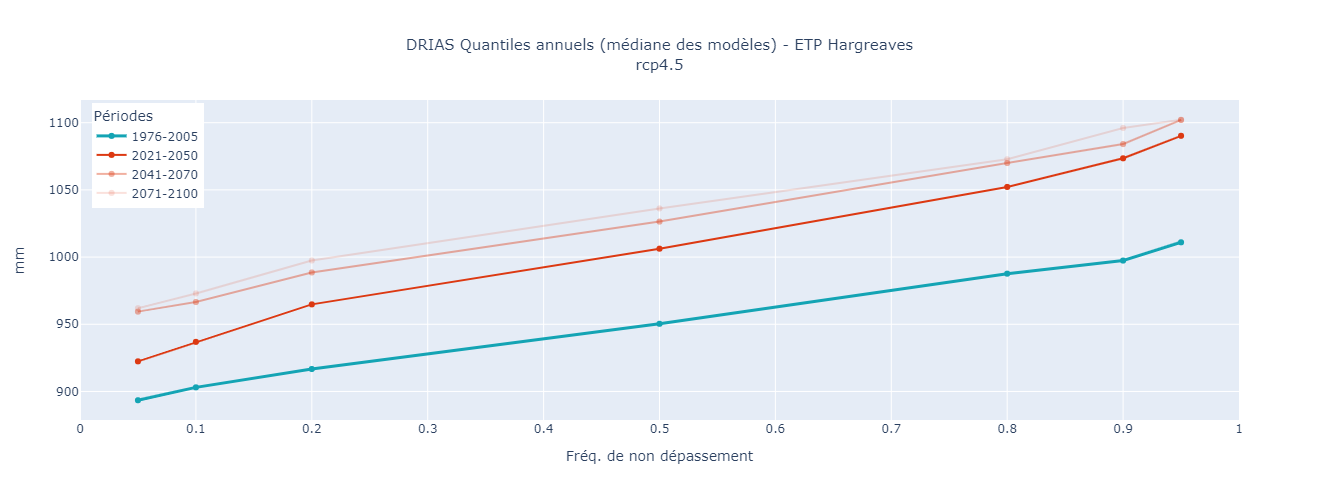

TypeError: scatter() got an unexpected keyword argument 'line'

In [102]:
import plotly.graph_objects as go
import plotly.subplots

# *************** df_monthly_quant: Subset ANNUEL des quantiles médians, pour le graphique des données annuelles
df_annual_quant= df_monthly_quant.loc[(period_historical_txt, 'Annuel')][2:-1].rename(period_historical_txt).to_frame()
df_annual_quant.rename_axis(columns= 'Période', inplace= True)
for j, period_txt in enumerate(periods_futur_txt):
    df_annual_quant[period_txt]= df_monthly_quant.loc[(period_txt, 'Annuel')][2:-1].rename(period_txt, inplace= True)
# display(df_annual_quant)

# *************** GRAPHIQUES de distribution de fréquence des valeurs annuelles (plotly)
pd.options.plotting.backend = "plotly"# replace default pandas backend (matplotlib) by plotly
# colors= px.colors.qualitative.D3 # https://www.geeksforgeeks.org/python-plotly-how-to-set-up-a-color-palette/
colors= ['rgb(31, 119, 180)', 'rgba(220,57,18,1)', 'rgba(220,57,18,0.4)', 'rgba(220,57,18,0.15)']
colors= ['rgb(20, 164, 180)', 'rgba(220,57,18,1)', 'rgba(220,57,18,0.4)', 'rgba(220,57,18,0.15)']
indic_title= 'DRIAS Quantiles annuels (médiane des modèles)'

# fig= plotly.subplots.make_subplots(rows=1, cols=2)
# fig.add_trace(px.line(df_annual_quant, color_discrete_sequence= colors, markers= True,

fig= df_annual_quant.plot(color_discrete_sequence= colors, markers= True,
                      title= indic_title + ' - ' + param_long + '<br>' + scenario,
                     )
        # , row= 1, col= 1)
fig['data'][0]['line']['width']= 3

fig.update_traces(mode= 'markers+lines', hovertemplate= '%{y:.1f}')
fig.update_layout(xaxis = dict(tickvals = [i/10 for i in range(0, 11)]), title_font_size= 15, width= 600, height= 500, title_x=0.5,
                 showlegend= True, yaxis_title= unite, xaxis_title= 'Fréq. de non dépassement', legend_title_text= "Périodes",
                 legend= dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                 hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)')
                 )
fig.update_xaxes(range=[0, 1])
fig.show()
fig.write_html(os.path.join(fld_out, indic_title + ' - ' + param_long + ' - ' + scenario + '.html'))
fig.write_image(os.path.join(fld_out, indic_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

# ............... df_annual_val: subset 'annuel' de df_monthly_quant 
df_annual_val= df_monthly_quant.reset_index()[df_monthly_quant.reset_index()['Mois']== 'Annuel']
df_annual_val= df_annual_val.set_index('Période')[[0.5, 'Moy.']]
df_annual_val.rename(columns={0.5: 'Médiane', 'Moy.': 'Moyenne'}, inplace= True)
df_annual_val.rename_axis(columns= 'Grandeur' , inplace= True)
if unite == 'mm':
    df_annual_val[['Médiane_delta', 'Moyenne_delta']]= (df_annual_val.iloc[:] - df_annual_val.iloc[0]) / df_annual_val.iloc[0]
elif unite == '°C':
    df_annual_val[['Médiane_delta', 'Moyenne_delta']]= (df_annual_val.iloc[:] - df_annual_val.iloc[0])

# *************** Graphique d'évolution de la moyenne/médiane annuelle (plotly)
colors= ['rgba(220,57,18,0.5)', 'rgba(166, 216, 84, 1)']
indic_title2= 'DRIAS Evolution de la valeur annuelle'

# fig = df_annual_val[['Médiane', 'Moyenne']].plot(width= 600, height= 500, color_discrete_sequence= colors, markers= True,
#               title= indic_title2 + ' - ' + param + ' ' + scenario)

# NB: Le besoin d'étiquetter les points (argument 'text=') impose d'utiliser 'melt' pour convertir le dataframe 2D/wide-form en 1D/long-form (car l'argument 'text=' ne supporte pas un tableau 2D)
# https://towardsdatascience.com/visualization-with-plotly-express-comprehensive-guide-eb5ee4b50b57
df_melted= pd.melt(df_annual_val, value_vars= df_annual_val.columns, ignore_index= False).reset_index()
if unite == 'mm':
    df_text= (df_melted[df_melted['Grandeur'].isin(['Médiane_delta', 'Moyenne_delta'])]['value']*100).round(1).apply(str) + '%'# alternative non utilisée à 'texttemplate'
    texttemplate= '%{text:+.1%}'
elif unite == '°C':
    df_text= (df_melted[df_melted['Grandeur'].isin(['Médiane_delta', 'Moyenne_delta'])]['value']).round(1).apply(str) + '°C'   # alternative non utilisée à 'texttemplate'
    texttemplate= '%{text:+.2F}°C'    # résultat OK mais fonctionnement NON CONFORME A LA DESCRIPTION https://plotly.com/python/reference/pie/#pie-texttemplate

fig= px.scatter(df_melted[df_melted['Grandeur'].isin(['Médiane', 'Moyenne'])], x= 'Période', y= 'value', color= 'Grandeur', color_discrete_sequence= colors,
                # text= df_text,
                text= df_melted[df_melted['Grandeur'].isin(['Médiane_delta', 'Moyenne_delta'])]['value'],
                title= indic_title2 + ' - ' + param_long + '<br>' + scenario)

fig.update_traces(mode= 'markers+lines+text', hovertemplate= '%{y:.1f}', textposition='top center', texttemplate=  texttemplate) # formatage 'texttemplate' permettant d'afficher un signe systématique devant le nombre)
fig.update_layout(width= 600, height= 500, title_font_size= 15, title_x=0.5,
                 showlegend= True, yaxis_title= unite, xaxis_title= 'Période', legend_title_text= "Valeur annuelle...", legend_title_font_size= 12,
                 # legend= dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
                 hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)')
                 )
fig.show()
fig.write_html(os.path.join(fld_out, indic_title2 + ' - ' + param_long + ' - ' + scenario + '.html'))
fig.write_image(os.path.join(fld_out, indic_title2 + '.png'))# needs installation of "plotly-orca" or "kaleido"

## Essai de graphiques EN CHANTIER

In [122]:
fig.layout

Layout({
    'annotations': [{'font': {'size': 16},
                     'showarrow': False,
                     'text': '1976-2005',
                     'x': 0.225,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': '2021-2050',
                     'x': 0.775,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 1.0,
                     'yanchor': 'bottom',
                     'yref': 'paper'},
                    {'font': {'size': 16},
                     'showarrow': False,
                     'text': '2041-2070',
                     'x': 0.225,
                     'xanchor': 'center',
                     'xref': 'paper',
                     'y': 0.375,
                 

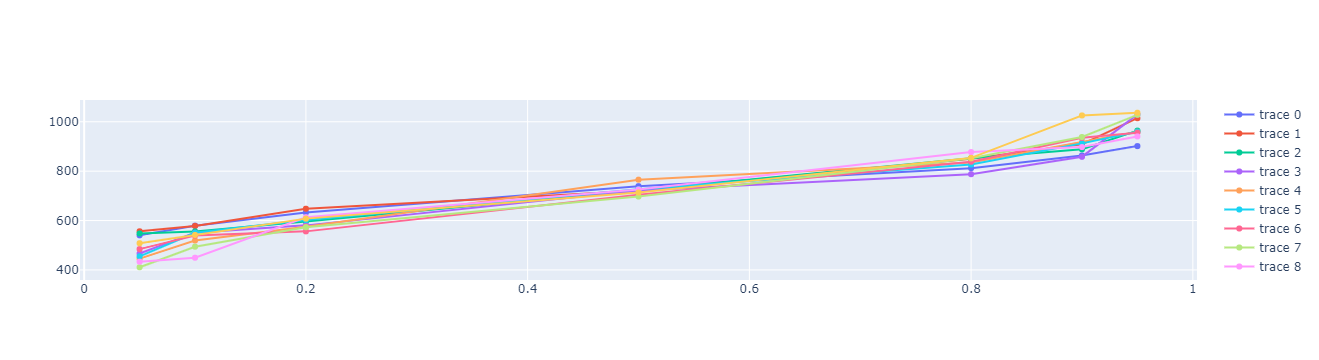

'2071-2100'

In [204]:
fig= go.Figure()
df_temp= df_annual_quant.loc[period_historical_txt] 
for y in df_temp.values:
    fig.add_trace(go.Scatter(x= df_temp.T.index, y= y,))
fig.show()
period

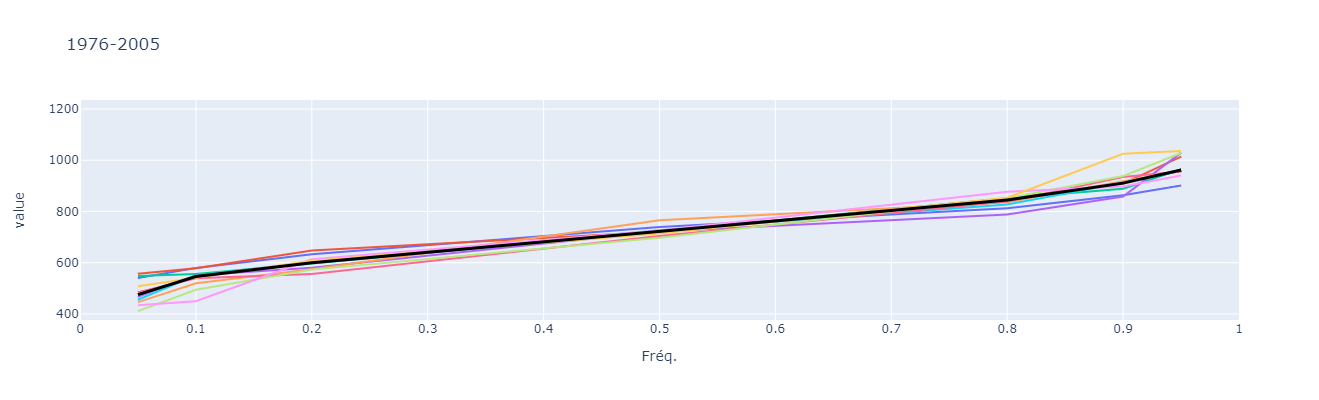

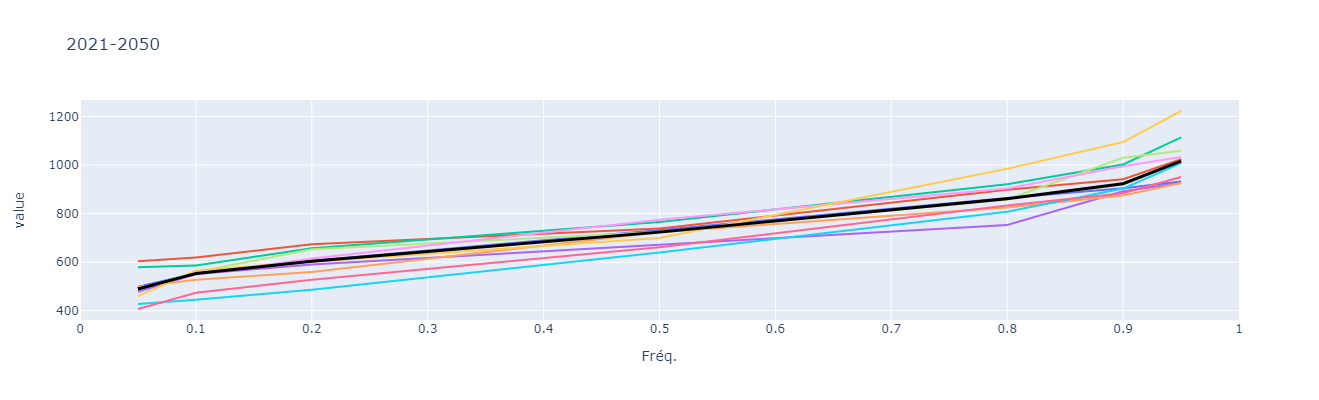

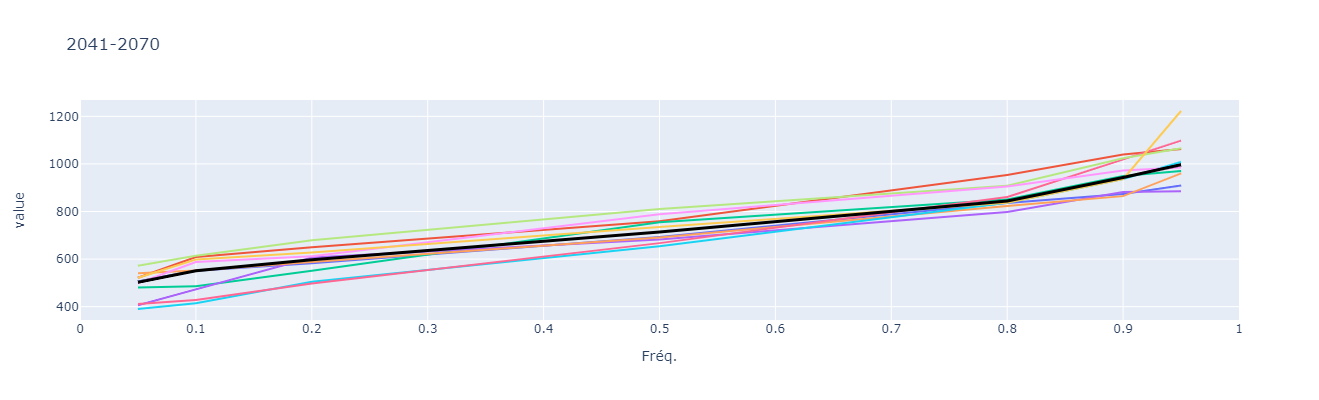

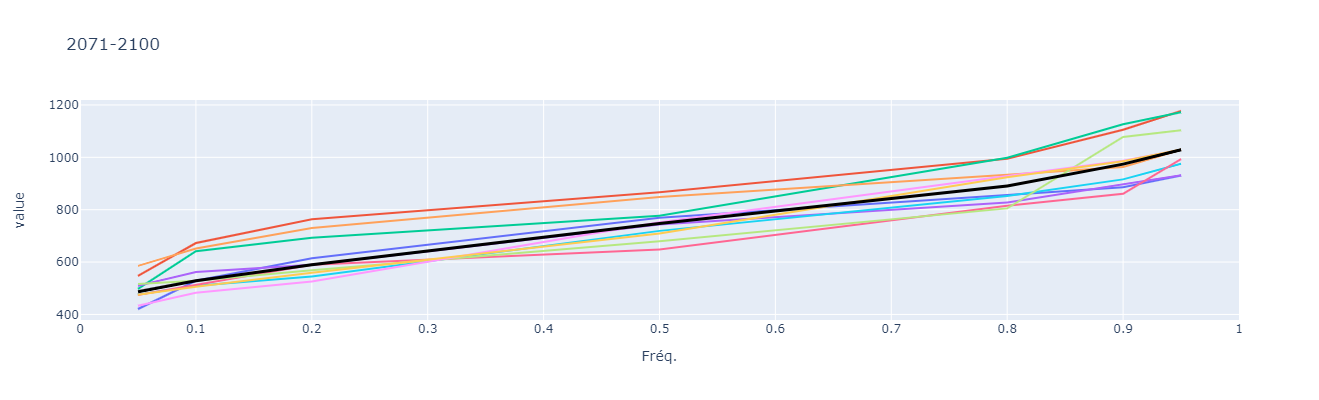

In [153]:
# *************** df_annual_quant: subset 'annuel quantile' de df_monthly_quant 
df_annual_quant= df_stat_multi.reset_index()[df_stat_multi.reset_index()['Mois']== 'Annuel']
df_annual_quant= df_annual_quant.set_index(['Période', 'Modèle'])[frequences]
df_annual_quant.rename_axis(columns= 'Fréq.' , inplace= True)
df_annual_quant.sort_index(axis=0, inplace= True)
df_annual_quant.sort_index(axis=1, inplace= True)

df_temp= df_annual_quant.loc[period_historical_txt] 
fig= df_temp.T.plot(width= 500, height= 400, title= period_historical_txt,)
fig.add_trace(go.Scatter(x= df_temp.median(axis=0).index, y= df_temp.median(axis=0).values, mode="lines", line= dict(color= 'black', width= 3), name= 'Médiane'))
fig.update_traces(mode= 'lines', hovertemplate= '%{y:.1f}')
fig.update_layout( showlegend= False, xaxis = dict(tickvals = [i/10 for i in range(0, 11)]), hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
fig.update_xaxes(range=[0, 1])
fig.show()
for period in periods_futur_txt:
    df_temp= df_annual_quant.loc[period]
    fig= df_temp.T.plot(width= 500, height= 400, title= period)
    fig.add_trace(go.Scatter(x= df_temp.median(axis=0).index, y= df_temp.median(axis=0).values, mode="lines", line= dict(color= 'black', width= 3), name= 'Médiane'))
    fig.update_traces(mode= 'lines', hovertemplate= '%{y:.1f}')
    fig.update_layout( showlegend= False, xaxis = dict(tickvals = [i/10 for i in range(0, 11)]), hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
    fig.update_xaxes(range=[0, 1])
    fig.show()

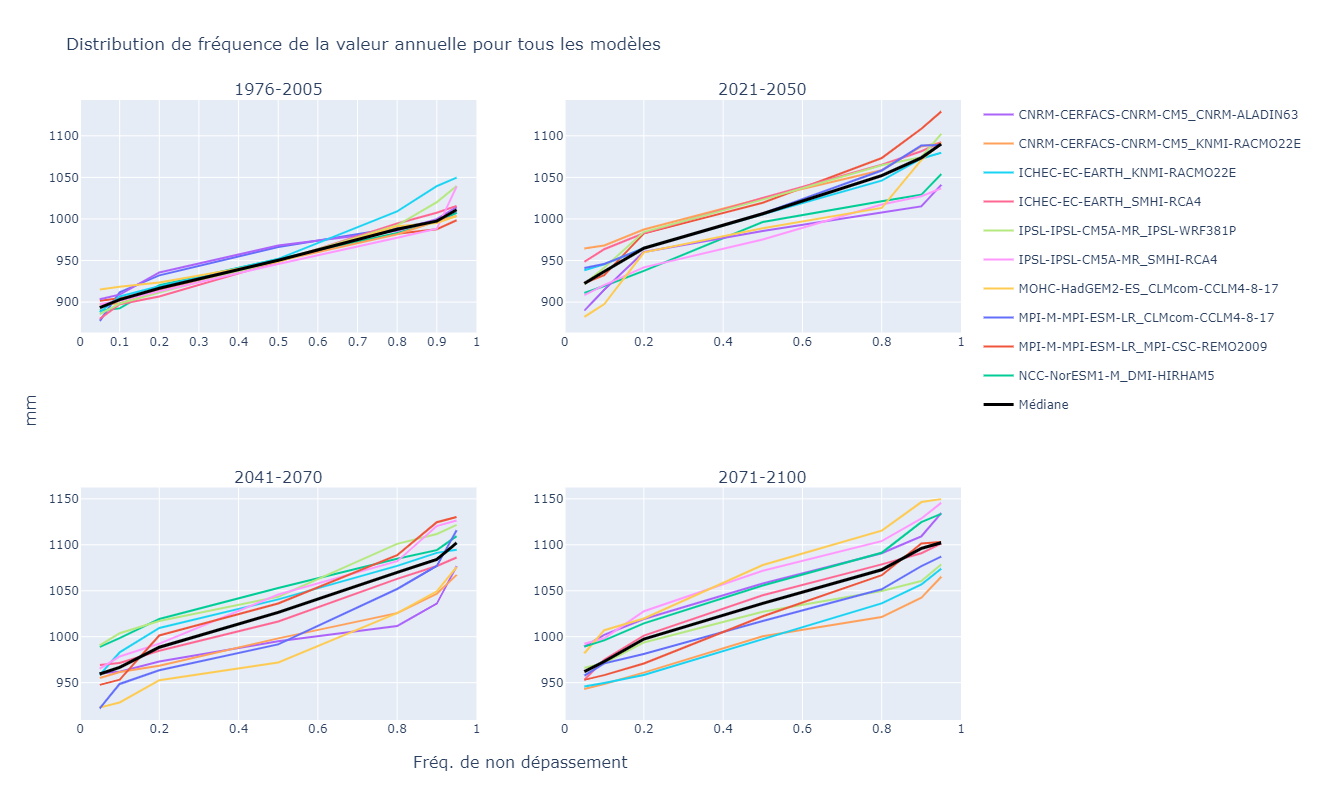

In [137]:
# *************** df_annual_quant: subset 'annuel quantile' de df_monthly_quant 
# ATTENTION: la couleur des traces n'est pas conforme à la légende car la gamme de couleurs n'est pas réinitialisée à chaque graphique

import plotly.subplots

# ............... df_annual_quant_multi: subset de df_stat_multi avec uniquement les quantiles ANNUELS pour le graphique
df_annual_quant_multi= df_stat_multi.reset_index()[df_stat_multi.reset_index()['Mois']== 'Annuel']
df_annual_quant_multi= df_annual_quant_multi.set_index(['Période', 'Modèle'])[frequences]
df_annual_quant_multi.rename_axis(columns= 'Fréq.' , inplace= True)
df_annual_quant_multi.sort_index(axis=0, inplace= True)
df_annual_quant_multi.sort_index(axis=1, inplace= True)

# ............... Grapqhique subplots (plotly)
colors= px.colors.qualitative.Pastel2
fig = plotly.subplots.make_subplots(rows=2, cols=2, subplot_titles= [period_historical_txt] + periods_futur_txt, x_title= 'Fréq. de non dépassement', y_title= unite,
                                    shared_yaxes= True) # ,shared_xaxes= True)
row= 1
col= 1
leg_bool=  False
for period in df_monthly_quant.reset_index()['Période'].unique():
    df_temp= df_annual_quant_multi.loc[period]
    if row==2 and col==2:
        leg_bool= True
    for i, (y, name) in enumerate(zip(df_temp.values, df_temp.index)):
        fig.add_trace(go.Scatter(x= df_temp.T.index, y= y, name= name, legendgroup= name, showlegend= leg_bool, ),
                      row= row, col= col)
    fig.add_trace(go.Scatter(x= df_temp.median(axis=0).index, y= df_temp.median(axis=0).values, mode="lines", line= dict(color= 'black', width= 3, ), 
                             name= 'Médiane', legendgroup= 'Médiane', showlegend= leg_bool), 
                  row= row, col= col)
    fig.update_traces(mode= 'lines', hovertemplate= '%{y:.1f}')
    fig.update_layout(width= 1100, height= 800, xaxis = dict(tickvals = [i/10 for i in range(0, 11)]), hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
    fig.update_layout(yaxis_showticklabels=True, yaxis2_showticklabels=True, yaxis3_showticklabels=True, yaxis4_showticklabels=True)
    fig.update_xaxes(range= [0, 1])
    col+= 1
    if col>2:
        col= 1
        row= 2
quant_multi_title= 'Distribution de fréquence de la valeur annuelle pour tous les modèles'
fig.update_layout(title_text= quant_multi_title)
fig.show()
fig.write_html(os.path.join(fld_out, quant_multi_title + ' - ' + param_long + ' - ' + scenario + '.html'))
fig.write_image(os.path.join(fld_out, quant_multi_title + '.png'))# needs installation of "plotly-orca" or "kaleido"

# for period in periods_futur_txt:
#     df_temp= df_annual_quant.loc[period]
#     fig= df_temp.T.plot(width= 500, height= 400, title= period)
#     fig.add_trace(go.Scatter(x= df_temp.median(axis=0).index, y= df_temp.median(axis=0).values, mode="lines", line= dict(color= 'black', width= 3), name= 'Médiane'))
#     fig.update_traces(mode= 'lines', hovertemplate= '%{y:.1f}')
#     fig.update_layout( showlegend= False, xaxis = dict(tickvals = [i/10 for i in range(0, 11)]), hovermode= "x unified", hoverlabel= dict(bgcolor='rgba(255,255,255,0.6)'))
#     fig.update_xaxes(range=[0, 1])
#     fig.show()

## 6) Enregistrement des résultats dans un fichier Excel (données de bases et indicateur)
Séries chronologiques journalières et mensuelles, quantiles mensuels et annuels pour chaque modèle et INDICATEUR FINAL (médiane des quantiles des différents modèles)

In [104]:
# *************** ENREGISTREMENT DES RESULTATS DANS UN FICHIER EXCEL
# ............... fonction pour enregistrer l'entête des données dans chaque onglet
def write_header():
    worksheet = writer.sheets[sheet_name]
    worksheet.write('A1', 'Scénario=')
    worksheet.write('A2', 'Paramètre=')
    worksheet.write('A3', 'Unité=')
    worksheet.write('A4', 'Points=')
    worksheet.write('A5', sheet_name)
    worksheet.write('B1', scenario)
    worksheet.write('B2', param + '= ' + param_long)
    worksheet.write('B3', unite)
    worksheet.write('B4', ', '.join(str(e) for e in points))
    return worksheet

# ............... Création du fichier Excel
excel_file = 'DRIAS quotidien - Indicateur personalisé.xlsx'
writer = pd.ExcelWriter(os.path.join(fld_out, excel_file), engine= 'xlsxwriter')
workbook  = writer.book
nround= 1 # nombre de chiffres après la virgule pour les valeurs climatiques
for i, (df_daily, df_monthly) in enumerate(
                                            zip([df_daily_h, df_daily_f],
                                               [df_monthly_h,df_monthly_f])):
    # df2= df_daily[param].to_frame()
    # df2.rename(columns= {param: models[num_model]}, inplace= True)# A FAIRE: Incrémenter le nom du modèle quand plusieurs modèles seront traités

    if i==0:
        sheet_name= 'quotidien historique'
    elif i==1:
        sheet_name= 'quotidien futur'
    df_daily.round(nround).to_excel(writer, sheet_name= sheet_name, startrow=5, engine= 'xlsxwriter')
    write_header()
    if os.path.exists(os.path.join(fld_out, daily_title + '.png')):
        worksheet.insert_image('D6', os.path.join(fld_out, daily_title + '.png'))

    if i==0:
        sheet_name= 'mensuel historique'
    elif i==1:
        sheet_name= 'mensuel futur'
    df_monthly.round(nround).to_excel(writer, sheet_name= sheet_name, startrow=5, engine= 'xlsxwriter')
    write_header()
    if os.path.exists(os.path.join(fld_out, monthly_title + '.png')):
        worksheet.insert_image('D6', os.path.join(fld_out, monthly_title + '.png'))

sheet_name= 'quantiles mensuels'
df_stat_multi.round(nround).to_excel(writer, sheet_name= sheet_name, startrow=5, engine= 'xlsxwriter')
worksheet= write_header()
if os.path.exists(os.path.join(fld_out, quant_multi_title + '.png')):
    worksheet.insert_image('N7', os.path.join(fld_out, quant_multi_title + '.png'))

sheet_name= 'indicateur quantiles médians'
df_monthly_quant.round(nround).to_excel(writer, sheet_name= sheet_name, startrow= 5, startcol= 0, engine= 'xlsxwriter')    # Quantiles MENSUELS/ANNUELS (médianes des modèles)
df_annual_quant.T.round(nround).to_excel(writer, sheet_name= sheet_name, startrow= 1, startcol= 13, engine= 'xlsxwriter')  # Quantiles ANNUELS médians (médianes des modèles)
df_annual_val.to_excel(writer, sheet_name= sheet_name, startrow= 1, startcol= 22, engine= 'xlsxwriter')                    # Moyenne & Médiane ANNUELLES (médianes des modèles)

worksheet= write_header()
if unite == 'mm':
    worksheet.write('N1', 'Quantiles de valeur annuelle (mm)')
    worksheet.write('W1', 'Moyenne/médiane annuelles (mm) & écart (%) / période de référence')
elif unite == '°C':
    worksheet.write('N1', 'Quantiles de valeur annuelle (°C)')
    worksheet.write('W1', 'Moyenne/médiane annuelles (°C) & écart (°C) / période de référence')
    
if os.path.exists(os.path.join(fld_out, indic_title + '.png')):
    worksheet.insert_image('M7', os.path.join(fld_out, indic_title + '.png'))
if os.path.exists(os.path.join(fld_out, indic_title2 + '.png')):
    worksheet.insert_image('W7', os.path.join(fld_out, indic_title2 + '.png'))
if os.path.exists(os.path.join(fld_out, map_title + '.png')):
    worksheet.insert_image('M32', os.path.join(fld_out, map_title + '.png'))
writer.save()

# ++++++++++ Delete image files after insertion in excel file
if os.path.exists(os.path.join(fld_out, daily_title + '.png')):
    os.remove(os.path.join(fld_out, daily_title + '.png'))
if os.path.exists(os.path.join(fld_out, monthly_title + '.png')):
    os.remove(os.path.join(fld_out, monthly_title + '.png'))
if os.path.exists(os.path.join(fld_out, yearly_title + '.png')):
    os.remove(os.path.join(fld_out, yearly_title + '.png'))
if os.path.exists(os.path.join(fld_out, quantile_title + '.png')):
    os.remove(os.path.join(fld_out, quantile_title + '.png'))
if os.path.exists(os.path.join(fld_out, indic_title + '.png')):
    os.remove(os.path.join(fld_out, indic_title + '.png'))
if os.path.exists(os.path.join(fld_out, indic_title2 + '.png')):
    os.remove(os.path.join(fld_out, indic_title2 + '.png'))
if os.path.exists(os.path.join(fld_out, map_title + '.png')):
    os.remove(os.path.join(fld_out, map_title + '.png'))
if os.path.exists(os.path.join(fld_out, quant_multi_title + '.png')):
    os.remove(os.path.join(fld_out, quant_multi_title + '.png'))
    
print('Enregistrement terminé du fichier excel')

Enregistrement terminé du fichier excel


In [77]:
df_annual_val


Grandeur,Médiane,Moyenne,Médiane_delta,Moyenne_delta
Période,,,,
1976-2005,817.30,115.05,0.000000,0.000000
2021-2050,774.55,113.45,-0.052306,-0.013907
2041-2070,765.40,109.30,-0.063502,-0.049978
2071-2100,842.85,127.20,0.031261,0.105606
